In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Conv2D,Dense,Flatten,BatchNormalization,Dropout,MaxPooling2D

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import L1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16 as vgg

# The classes are:

| Label | Description |
|:-----:|-------------|
|   0   | airplane    |
|   1   | automobile  |
|   2   | bird        |
|   3   | cat         |
|   4   | deer        |
|   5   | dog         |
|   6   | frog        |
|   7   | horse       |
|   8   | ship        |
|   9   | truck       |

In [2]:
classe_dict = {
0:"airplane" ,   
1:"automobile" , 
2:"bird" ,       
3:"cat" ,        
4:"deer",        
5:"dog" ,        
6:"frog" ,       
7:"horse",       
8:"ship",       
9:"truck",       
}

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.10,random_state = 42)

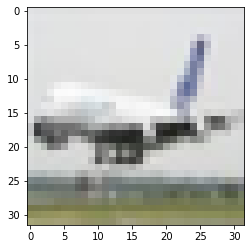

In [5]:
## Before resizing
import cv2
y_train[2] #-->airplane
plt.imshow(x_train[2])

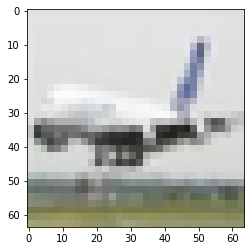

In [6]:
## After resizing
sample_resized = cv2.resize(x_train[2],(64,64),interpolation = cv2.INTER_AREA)
plt.imshow(sample_resized)

## Resizing the data to 64*64*3

In [7]:
x_train = np.array([cv2.resize(i,(64,64),interpolation = cv2.INTER_AREA) for i in x_train])
x_val  = np.array([cv2.resize(i,(64,64),interpolation = cv2.INTER_AREA) for i in x_val])
X_test  = np.array([cv2.resize(i,(64,64),interpolation = cv2.INTER_AREA) for i in x_test])

## Normalise the X_test

In [8]:
X_test = X_test/255.0

## Encoding the target variables 

In [9]:
y_train = to_categorical(y_train,10)
y_val = to_categorical(y_val,10)
y_test = to_categorical(y_test,10)

## Base Model

In [10]:
input_shape = x_train[0].shape
no_of_classes = 10

#set the input shape of base model equal to 64*64*3
basemodel = vgg.VGG16(include_top=False,weights='imagenet',input_shape=input_shape,classes=no_of_classes)

print(f"Basemodel Input shape{basemodel.input_shape}")
print(f"Basemodel output shape{basemodel.output_shape}")

Basemodel Input shape(None, 64, 64, 3)
Basemodel output shape(None, 2, 2, 512)


In [11]:
print("##################### Basemodel Summary######################")
print("#############################################################")
print("\n")
basemodel.summary()

##################### Basemodel Summary######################
#############################################################


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
 

## Model 1

## Taking the output of first theree blocks only

In [12]:
block3_output = basemodel.get_layer('block3_pool').output

## Perform batch Normalisation and Flatten the output
x= BatchNormalization()(block3_output)
x = Flatten()(x)

#Adding the Dense layers

x = Dense(512,activation=('relu'))(x)
x = Dense(256,activation=('relu'))(x)
output = Dense(no_of_classes,activation=('softmax'))(x)
#This is the classification layer

## Model 1 Summary

In [13]:
model = Model(inputs=basemodel.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

### donot train the layers in base model

In [14]:
for layer in basemodel.layers:
    layer.trainable = False

In [15]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss=CategoricalCrossentropy(),metrics=['accuracy'])

In [16]:
no_of_epochs = 10
batch_size = 64


train_datagen = ImageDataGenerator(horizontal_flip=True,rescale=1.0/255)
train_datagen.fit(x_train)
train_datagenerator = train_datagen.flow(x_train,y_train,batch_size=batch_size)

In [17]:
val_datagen = ImageDataGenerator(horizontal_flip=True,rescale=1.0/255)
val_datagen.fit(x_val)
val_datagenerator = val_datagen.flow(x_val,y_val,batch_size=batch_size)

In [18]:
train_steps_per_epoch = x_train.shape[0]//batch_size
val_steps_per_epoch = x_val.shape[0]//batch_size

hist = model.fit(train_datagenerator,steps_per_epoch=train_steps_per_epoch,validation_data=val_datagenerator,
                 validation_steps=val_steps_per_epoch,epochs=no_of_epochs,verbose=1)

Epoch 1/10
703/703 [==============================] - 634s 900ms/step - loss: 0.7667 - accuracy: 0.7358 - val_loss: 0.6011 - val_accuracy: 0.7937
Epoch 2/10
703/703 [==============================] - 609s 866ms/step - loss: 0.4371 - accuracy: 0.8519 - val_loss: 0.5385 - val_accuracy: 0.8171
Epoch 3/10
703/703 [==============================] - 600s 854ms/step - loss: 0.3075 - accuracy: 0.8988 - val_loss: 0.5182 - val_accuracy: 0.8297
Epoch 4/10
703/703 [==============================] - 593s 844ms/step - loss: 0.2189 - accuracy: 0.9297 - val_loss: 0.5268 - val_accuracy: 0.8351
Epoch 5/10
703/703 [==============================] - 575s 818ms/step - loss: 0.1613 - accuracy: 0.9491 - val_loss: 0.5433 - val_accuracy: 0.8345
Epoch 6/10
703/703 [==============================] - 537s 764ms/step - loss: 0.1274 - accuracy: 0.9595 - val_loss: 0.5585 - val_accuracy: 0.8423
Epoch 7/10
703/703 [==============================] - 641s 912ms/step - loss: 0.0767 - accuracy: 0.9758 - val_loss: 0.6025 -

In [19]:
model.save("cifar10_vgg16_Model1.h5")

C:\Users\nswet\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model 1 Evalaution

In [20]:
scores = model.evaluate(X_test,y_test)

print(f"Test Accuracy {np.round(scores[1]*100,2)}%")

313/313 [==============================] - 99s 314ms/step - loss: 0.6547 - accuracy: 0.8382
Test Accuracy 83.82%


## Model 2 -  Regularisation using Drop Out

In [21]:
## Add our dense layers
x= BatchNormalization()(block3_output)
x = Flatten()(x)

#Adding the Dense layers

x = Dense(512,activation=('relu'))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(256,activation=('relu'))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
output_1= Dense(no_of_classes,activation=('softmax'))(x)
#This is the classification layer

model_1 = Model(inputs=basemodel.input, outputs=output_1)
model_1.summary()

opt = Adam(learning_rate=0.0001)

model_1.compile(optimizer=opt,loss=CategoricalCrossentropy(),metrics=['accuracy'])
hist_1 = model_1.fit(train_datagenerator,steps_per_epoch=train_steps_per_epoch,validation_data=val_datagenerator,
                 validation_steps=val_steps_per_epoch,epochs=no_of_epochs,verbose=1)
model_1.save("cifar10_vgg16_rev_1.h5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [22]:
model_1.save("cifar10_vgg16_Model2.h5")

## Model2 Evalaution

In [23]:
scores_1 = model_1.evaluate(X_test,y_test)
print(f"Test Accuracy {np.round(scores_1[1]*100,2)}")

313/313 [==============================] - 115s 367ms/step - loss: 0.4936 - accuracy: 0.8398
Test Accuracy 83.98


In [24]:
print(f"Test Accuracy {np.round(scores_1[1]*100,2)}%")

Test Accuracy 83.98%


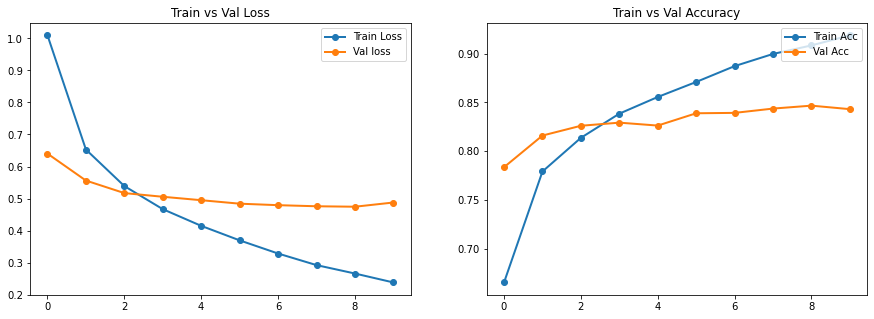

In [25]:
train_loss = hist_1.history["loss"]
val_loss = hist_1.history["val_loss"]

train_acc = hist_1.history["accuracy"]
val_acc = hist_1.history["val_accuracy"]

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(list(range(no_of_epochs)),train_loss,marker='o',linewidth=2)
plt.plot(list(range(no_of_epochs)),val_loss,marker='o',linewidth=2)
plt.title("Train vs Val Loss")
plt.legend(["Train Loss", "Val loss"],loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(list(range(no_of_epochs)),train_acc,marker='o',linewidth=2)
plt.plot(list(range(no_of_epochs)),val_acc,marker='o',linewidth=2)
plt.title("Train vs Val Accuracy")
plt.legend(["Train Acc", "Val Acc"],loc = 'upper right')

plt.show()

##  Classification Report

In [26]:
predictions = model_1.predict(X_test)
y_pred = np.argmax(predictions,axis =1)

y_true = np.argmax(y_test,axis =1)

313/313 [==============================] - 111s 354ms/step


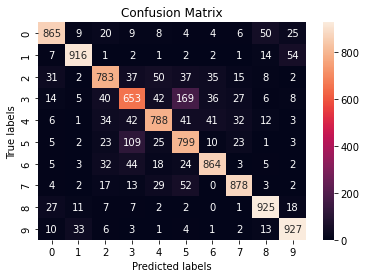

In [27]:
cm = confusion_matrix(y_true,y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [28]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1000
           1       0.93      0.92      0.92      1000
           2       0.81      0.78      0.80      1000
           3       0.71      0.65      0.68      1000
           4       0.82      0.79      0.80      1000
           5       0.70      0.80      0.75      1000
           6       0.87      0.86      0.87      1000
           7       0.89      0.88      0.88      1000
           8       0.89      0.93      0.91      1000
           9       0.89      0.93      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Plotting predictions and true labels

In [29]:
def display_image(X_test, indexes, y_true,y_pred):

    # plot first few images
    plt.figure(figsize=(12,12))
    
    for i in range(len(indexes)):

        # Get image data
        img = X_test[indexes[i]]
        
        # Get predicted label
        predicted_label = y_pred[indexes[i]]
        
        # Get true label
        true_label = y_true[indexes[i]]
        true_class_label = classe_dict[true_label]



        # define subplot
        plt.subplot(330 + 1 + i)
        plt.title('Preicted Label: %s \n'%predicted_label+\
                 'True Label: %s\n'%true_label+\
                  'True Class: %s\n'%true_class_label,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(img)

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()

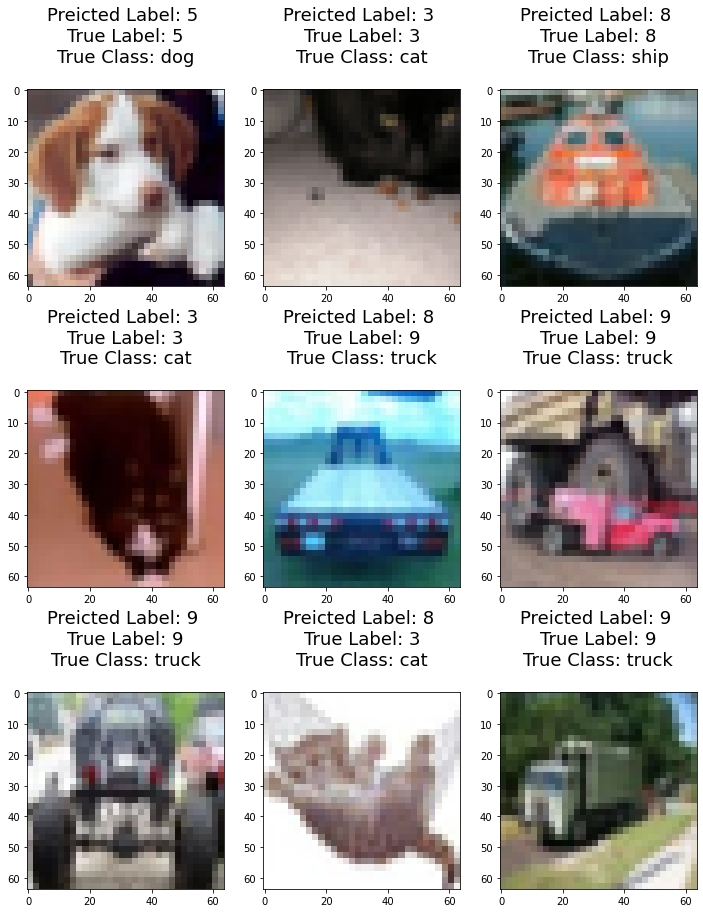

In [30]:
# plotting random images 
# their true and predicted labels
no_of_images = 9 
indexes = [random.randint(0,len(X_test)) for i in range(no_of_images)]
display_image(X_test,indexes,y_true,y_pred)